In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import os
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import cv2

In [ ]:
# Set image size, batch size, and normalization statistics
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# Create a DataLoader for the training and validation dataset
dataset = ImageFolder('/kaggle/input/cat-dataset',
    transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)
    ])
)

In [ ]:
# Split the dataset into training and validation sets
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=False, num_workers=3, pin_memory=True)


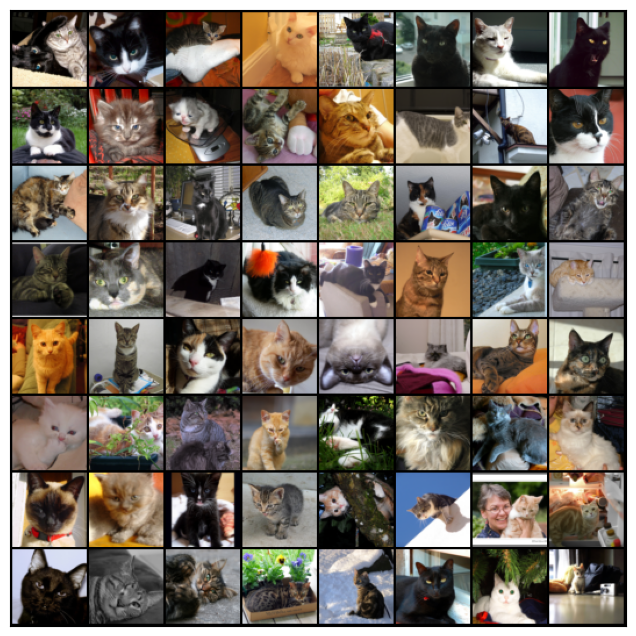

In [ ]:
# Function to denormalize image tensors
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# Function to display a batch of images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

# Display a batch of images from the DataLoader
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
# Function to get the default device (GPU if available, else CPU)
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to move data to the chosen device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# DataLoader wrapper to move data to a device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
# Define the Discriminator network
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = to_device(discriminator, device)

In [ ]:
# Define the Generator network
latent_size = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)
generator = to_device(generator, device)

In [ ]:
# Function to train the Discriminator
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Function to train the Generator
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    loss.backward()
    opt_g.step()
    return loss.item()


In [ ]:
# Function to validate the Discriminator (calculate validation loss)
def validate_discriminator(val_dl):
    with torch.no_grad():
        val_loss_d = 0.0
        for real_images, _ in val_dl:
            real_preds = discriminator(real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = F.binary_cross_entropy(real_preds, real_targets)
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = discriminator(fake_images)
            fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
            val_loss_d += (real_loss + fake_loss).item()
    return val_loss_d / len(val_dl)

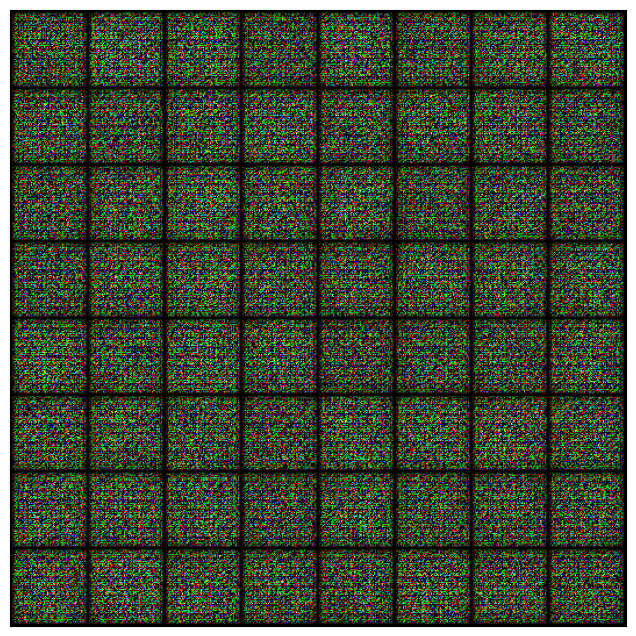

In [ ]:
# Function to save generated images
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [ ]:
# Function to train the GAN
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    val_losses_d = []
    real_scores = []
    fake_scores = []
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        val_loss_d = validate_discriminator(val_dl)
        val_losses_d.append(val_loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, val_loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, val_loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, val_losses_d, real_scores, fake_scores

In [ ]:
# Train the GAN for 200 epochs
epochs = 600
lr = 0.0002
history = fit(epochs, lr)
losses_g, losses_d,val_loss_d, real_scores, fake_scores = history

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/600], loss_g: 3.3667, loss_d: 0.2359, val_loss_d: 0.2512, real_score: 0.8778, fake_score: 0.0933


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/600], loss_g: 3.8155, loss_d: 0.3240, val_loss_d: 0.3541, real_score: 0.8434, fake_score: 0.1187


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/600], loss_g: 4.5747, loss_d: 0.2911, val_loss_d: 0.3092, real_score: 0.9164, fake_score: 0.1737


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/600], loss_g: 3.3243, loss_d: 0.2598, val_loss_d: 0.5040, real_score: 0.8427, fake_score: 0.0764


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/600], loss_g: 3.2875, loss_d: 0.3076, val_loss_d: 0.3703, real_score: 0.8145, fake_score: 0.0706


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/600], loss_g: 5.0517, loss_d: 0.2964, val_loss_d: 0.2400, real_score: 0.9324, fake_score: 0.1812


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/600], loss_g: 2.7173, loss_d: 0.6224, val_loss_d: 0.6612, real_score: 0.7094, fake_score: 0.1800


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/600], loss_g: 7.2446, loss_d: 1.0091, val_loss_d: 1.8625, real_score: 0.8529, fake_score: 0.4990


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/600], loss_g: 3.8779, loss_d: 0.6488, val_loss_d: 0.4911, real_score: 0.5900, fake_score: 0.0300


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/600], loss_g: 4.4419, loss_d: 0.5639, val_loss_d: 0.5652, real_score: 0.8750, fake_score: 0.3223


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [11/600], loss_g: 3.6229, loss_d: 0.3076, val_loss_d: 0.4582, real_score: 0.8430, fake_score: 0.1125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [12/600], loss_g: 4.3222, loss_d: 0.4013, val_loss_d: 0.4102, real_score: 0.8613, fake_score: 0.1879


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [13/600], loss_g: 5.2085, loss_d: 0.3559, val_loss_d: 0.2868, real_score: 0.9170, fake_score: 0.2053


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [14/600], loss_g: 3.3013, loss_d: 2.2893, val_loss_d: 0.5961, real_score: 0.1771, fake_score: 0.0005


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [15/600], loss_g: 4.8508, loss_d: 0.2383, val_loss_d: 0.2683, real_score: 0.8451, fake_score: 0.0528


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [16/600], loss_g: 2.6568, loss_d: 0.4129, val_loss_d: 0.4105, real_score: 0.7229, fake_score: 0.0417


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [17/600], loss_g: 6.3634, loss_d: 0.4259, val_loss_d: 0.3599, real_score: 0.9218, fake_score: 0.2664


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [18/600], loss_g: 5.5118, loss_d: 0.7562, val_loss_d: 0.8761, real_score: 0.8671, fake_score: 0.3721


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [19/600], loss_g: 2.0203, loss_d: 0.8790, val_loss_d: 0.8060, real_score: 0.5074, fake_score: 0.0503


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [20/600], loss_g: 5.0037, loss_d: 0.6695, val_loss_d: 0.6840, real_score: 0.8855, fake_score: 0.3696


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [21/600], loss_g: 1.9141, loss_d: 0.5205, val_loss_d: 0.8392, real_score: 0.6881, fake_score: 0.0846


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [22/600], loss_g: 3.0113, loss_d: 0.4883, val_loss_d: 0.6429, real_score: 0.8061, fake_score: 0.1852


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [23/600], loss_g: 3.4730, loss_d: 0.2547, val_loss_d: 0.3638, real_score: 0.8450, fake_score: 0.0676


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [24/600], loss_g: 3.3411, loss_d: 0.9686, val_loss_d: 0.3225, real_score: 0.4504, fake_score: 0.0062


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [25/600], loss_g: 1.8281, loss_d: 0.4435, val_loss_d: 0.7160, real_score: 0.7413, fake_score: 0.1005


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [26/600], loss_g: 2.5586, loss_d: 0.3965, val_loss_d: 0.3947, real_score: 0.7677, fake_score: 0.0953


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [27/600], loss_g: 6.1196, loss_d: 0.7733, val_loss_d: 1.1558, real_score: 0.9365, fake_score: 0.4522


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [28/600], loss_g: 2.2027, loss_d: 0.5435, val_loss_d: 0.7708, real_score: 0.7569, fake_score: 0.1802


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [29/600], loss_g: 2.5723, loss_d: 0.6105, val_loss_d: 0.4876, real_score: 0.6009, fake_score: 0.0100


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [30/600], loss_g: 4.7155, loss_d: 0.5972, val_loss_d: 0.4871, real_score: 0.8655, fake_score: 0.3194


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [31/600], loss_g: 2.2299, loss_d: 0.4142, val_loss_d: 0.4939, real_score: 0.7647, fake_score: 0.0889


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [32/600], loss_g: 3.1087, loss_d: 0.3518, val_loss_d: 0.3912, real_score: 0.8071, fake_score: 0.1034


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [33/600], loss_g: 2.6982, loss_d: 0.5073, val_loss_d: 0.5408, real_score: 0.6836, fake_score: 0.0557


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [34/600], loss_g: 4.1692, loss_d: 0.2614, val_loss_d: 0.4928, real_score: 0.9037, fake_score: 0.1248


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [35/600], loss_g: 4.5807, loss_d: 0.2362, val_loss_d: 0.5479, real_score: 0.9363, fake_score: 0.1423


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [36/600], loss_g: 4.1138, loss_d: 0.3526, val_loss_d: 0.5896, real_score: 0.8952, fake_score: 0.1847


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [37/600], loss_g: 2.8699, loss_d: 0.2290, val_loss_d: 0.4259, real_score: 0.8560, fake_score: 0.0542


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [38/600], loss_g: 2.8072, loss_d: 0.2063, val_loss_d: 0.3522, real_score: 0.9203, fake_score: 0.1030


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [39/600], loss_g: 2.5703, loss_d: 0.3202, val_loss_d: 0.3945, real_score: 0.8694, fake_score: 0.1456


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [40/600], loss_g: 4.1691, loss_d: 0.2918, val_loss_d: 0.5532, real_score: 0.9217, fake_score: 0.1736


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [41/600], loss_g: 3.0360, loss_d: 0.2632, val_loss_d: 0.4622, real_score: 0.9180, fake_score: 0.1460


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [42/600], loss_g: 2.1280, loss_d: 0.7491, val_loss_d: 0.4359, real_score: 0.5330, fake_score: 0.0093


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [43/600], loss_g: 2.9014, loss_d: 0.1682, val_loss_d: 0.3591, real_score: 0.9298, fake_score: 0.0827


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [44/600], loss_g: 3.7039, loss_d: 0.2546, val_loss_d: 0.4475, real_score: 0.8801, fake_score: 0.1058


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [45/600], loss_g: 4.3192, loss_d: 0.2263, val_loss_d: 0.4851, real_score: 0.8492, fake_score: 0.0436


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [46/600], loss_g: 3.4867, loss_d: 0.2234, val_loss_d: 0.4547, real_score: 0.9049, fake_score: 0.0989


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [47/600], loss_g: 0.0727, loss_d: 1.9049, val_loss_d: 3.5865, real_score: 0.2090, fake_score: 0.0005


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [48/600], loss_g: 3.3680, loss_d: 0.2566, val_loss_d: 0.2983, real_score: 0.9385, fake_score: 0.1598


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [49/600], loss_g: 2.3030, loss_d: 0.3990, val_loss_d: 0.5294, real_score: 0.8008, fake_score: 0.1201


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [50/600], loss_g: 3.2017, loss_d: 0.2821, val_loss_d: 0.3839, real_score: 0.9170, fake_score: 0.1607


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [51/600], loss_g: 3.3058, loss_d: 0.2170, val_loss_d: 0.3539, real_score: 0.8763, fake_score: 0.0703


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [52/600], loss_g: 0.5678, loss_d: 2.6379, val_loss_d: 2.4631, real_score: 0.3415, fake_score: 0.3278


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [53/600], loss_g: 2.0740, loss_d: 0.4670, val_loss_d: 0.5638, real_score: 0.6930, fake_score: 0.0504


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [54/600], loss_g: 3.4074, loss_d: 0.1578, val_loss_d: 0.3713, real_score: 0.9194, fake_score: 0.0651


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [55/600], loss_g: 3.8671, loss_d: 0.3808, val_loss_d: 0.6183, real_score: 0.8805, fake_score: 0.1878


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [56/600], loss_g: 3.4937, loss_d: 0.1164, val_loss_d: 0.3487, real_score: 0.9363, fake_score: 0.0450


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [57/600], loss_g: 3.5981, loss_d: 0.2063, val_loss_d: 0.3188, real_score: 0.9800, fake_score: 0.1548


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [58/600], loss_g: 3.3841, loss_d: 0.3548, val_loss_d: 0.5597, real_score: 0.8312, fake_score: 0.1100


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [59/600], loss_g: 2.4017, loss_d: 0.1955, val_loss_d: 0.3430, real_score: 0.8701, fake_score: 0.0437


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [60/600], loss_g: 3.3329, loss_d: 0.1331, val_loss_d: 0.3292, real_score: 0.9194, fake_score: 0.0431


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [61/600], loss_g: 3.7859, loss_d: 0.1300, val_loss_d: 0.4195, real_score: 0.9036, fake_score: 0.0220


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [62/600], loss_g: 2.7051, loss_d: 0.2452, val_loss_d: 0.4465, real_score: 0.8951, fake_score: 0.1112


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [63/600], loss_g: 3.1457, loss_d: 0.1705, val_loss_d: 0.3273, real_score: 0.8977, fake_score: 0.0520


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [64/600], loss_g: 3.1983, loss_d: 0.4557, val_loss_d: 0.8734, real_score: 0.9117, fake_score: 0.2340


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [65/600], loss_g: 3.4703, loss_d: 0.0750, val_loss_d: 0.3566, real_score: 0.9637, fake_score: 0.0362


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [66/600], loss_g: 0.4166, loss_d: 0.8008, val_loss_d: 1.7510, real_score: 0.5165, fake_score: 0.0026


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [67/600], loss_g: 4.4596, loss_d: 0.3695, val_loss_d: 0.5725, real_score: 0.9744, fake_score: 0.2474


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [68/600], loss_g: 3.7684, loss_d: 0.0763, val_loss_d: 0.4177, real_score: 0.9815, fake_score: 0.0541


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [69/600], loss_g: 3.9268, loss_d: 0.1165, val_loss_d: 0.3975, real_score: 0.9101, fake_score: 0.0141


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [70/600], loss_g: 4.0945, loss_d: 0.0670, val_loss_d: 0.3865, real_score: 0.9757, fake_score: 0.0397


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [71/600], loss_g: 2.5616, loss_d: 0.3391, val_loss_d: 0.6044, real_score: 0.8472, fake_score: 0.1248


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [72/600], loss_g: 3.7124, loss_d: 0.1338, val_loss_d: 0.4388, real_score: 0.9501, fake_score: 0.0722


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [73/600], loss_g: 4.1904, loss_d: 0.1723, val_loss_d: 0.4100, real_score: 0.9834, fake_score: 0.1310


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [74/600], loss_g: 4.4436, loss_d: 0.0805, val_loss_d: 0.5579, real_score: 0.9423, fake_score: 0.0191


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [75/600], loss_g: 3.8767, loss_d: 0.3105, val_loss_d: 0.7052, real_score: 0.8751, fake_score: 0.1206


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [76/600], loss_g: 3.8895, loss_d: 0.1626, val_loss_d: 0.4452, real_score: 0.9224, fake_score: 0.0700


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [77/600], loss_g: 4.2993, loss_d: 0.1194, val_loss_d: 0.4418, real_score: 0.9635, fake_score: 0.0749


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [78/600], loss_g: 3.7324, loss_d: 0.2340, val_loss_d: 0.6906, real_score: 0.9273, fake_score: 0.1227


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [79/600], loss_g: 4.9188, loss_d: 0.0980, val_loss_d: 0.5964, real_score: 0.9705, fake_score: 0.0612


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [80/600], loss_g: 3.9345, loss_d: 0.0928, val_loss_d: 0.3792, real_score: 0.9377, fake_score: 0.0251


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [81/600], loss_g: 4.5320, loss_d: 0.0703, val_loss_d: 0.4950, real_score: 0.9915, fake_score: 0.0564


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [82/600], loss_g: 4.0254, loss_d: 0.3998, val_loss_d: 0.8725, real_score: 0.8858, fake_score: 0.1799


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [83/600], loss_g: 4.2198, loss_d: 0.1383, val_loss_d: 0.4412, real_score: 0.9161, fake_score: 0.0420


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [84/600], loss_g: 3.8703, loss_d: 0.0944, val_loss_d: 0.4490, real_score: 0.9527, fake_score: 0.0419


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [85/600], loss_g: 2.3059, loss_d: 0.3629, val_loss_d: 0.5880, real_score: 0.7815, fake_score: 0.0533


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [86/600], loss_g: 4.3561, loss_d: 0.0521, val_loss_d: 0.5096, real_score: 0.9833, fake_score: 0.0329


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [87/600], loss_g: 4.2454, loss_d: 0.0643, val_loss_d: 0.4380, real_score: 0.9617, fake_score: 0.0217


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [88/600], loss_g: 3.6929, loss_d: 0.1215, val_loss_d: 0.4654, real_score: 0.9450, fake_score: 0.0569


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [89/600], loss_g: 4.2362, loss_d: 0.0632, val_loss_d: 0.4954, real_score: 0.9652, fake_score: 0.0247


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [90/600], loss_g: 4.3060, loss_d: 0.0673, val_loss_d: 0.4372, real_score: 0.9602, fake_score: 0.0246


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [91/600], loss_g: 4.1941, loss_d: 0.0618, val_loss_d: 0.4296, real_score: 0.9531, fake_score: 0.0120


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [92/600], loss_g: 4.1459, loss_d: 1.4574, val_loss_d: 1.8113, real_score: 0.9141, fake_score: 0.5941


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [93/600], loss_g: 4.5040, loss_d: 0.1581, val_loss_d: 0.6020, real_score: 0.9148, fake_score: 0.0541


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [94/600], loss_g: 4.8723, loss_d: 0.0668, val_loss_d: 0.6078, real_score: 0.9801, fake_score: 0.0431


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [95/600], loss_g: 5.5930, loss_d: 0.0540, val_loss_d: 0.7727, real_score: 0.9933, fake_score: 0.0440


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [96/600], loss_g: 4.6455, loss_d: 0.0551, val_loss_d: 0.5831, real_score: 0.9853, fake_score: 0.0379


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [97/600], loss_g: 5.1881, loss_d: 0.0639, val_loss_d: 0.5370, real_score: 0.9580, fake_score: 0.0194


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [98/600], loss_g: 4.9229, loss_d: 1.5237, val_loss_d: 2.6579, real_score: 0.9008, fake_score: 0.6217


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [99/600], loss_g: 0.7450, loss_d: 2.1504, val_loss_d: 1.8742, real_score: 0.2699, fake_score: 0.0124


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [100/600], loss_g: 4.9503, loss_d: 0.0894, val_loss_d: 0.8659, real_score: 0.9398, fake_score: 0.0246


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [101/600], loss_g: 4.4607, loss_d: 0.0953, val_loss_d: 0.6188, real_score: 0.9263, fake_score: 0.0145


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [102/600], loss_g: 4.8229, loss_d: 0.0380, val_loss_d: 0.7275, real_score: 0.9890, fake_score: 0.0257


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [103/600], loss_g: 3.5225, loss_d: 0.2908, val_loss_d: 0.8435, real_score: 0.8702, fake_score: 0.0993


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [104/600], loss_g: 4.3039, loss_d: 0.0710, val_loss_d: 0.5125, real_score: 0.9676, fake_score: 0.0344


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [105/600], loss_g: 4.4152, loss_d: 0.0550, val_loss_d: 0.6037, real_score: 0.9780, fake_score: 0.0308


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [106/600], loss_g: 4.9011, loss_d: 0.0478, val_loss_d: 0.6257, real_score: 0.9810, fake_score: 0.0270


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [107/600], loss_g: 5.2114, loss_d: 0.0316, val_loss_d: 0.7134, real_score: 0.9916, fake_score: 0.0222


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [108/600], loss_g: 5.0720, loss_d: 0.1398, val_loss_d: 0.8850, real_score: 0.9470, fake_score: 0.0698


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [109/600], loss_g: 3.9444, loss_d: 0.0938, val_loss_d: 0.5437, real_score: 0.9437, fake_score: 0.0289


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [110/600], loss_g: 3.8215, loss_d: 0.0744, val_loss_d: 0.4442, real_score: 0.9452, fake_score: 0.0160


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [111/600], loss_g: 3.1205, loss_d: 0.0915, val_loss_d: 0.4013, real_score: 0.9310, fake_score: 0.0164


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [112/600], loss_g: 2.8342, loss_d: 0.2760, val_loss_d: 0.6117, real_score: 0.8300, fake_score: 0.0440


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [113/600], loss_g: 4.2966, loss_d: 0.1099, val_loss_d: 0.6342, real_score: 0.9485, fake_score: 0.0502


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [114/600], loss_g: 4.5250, loss_d: 0.0638, val_loss_d: 0.6812, real_score: 0.9703, fake_score: 0.0317


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [115/600], loss_g: 4.8286, loss_d: 0.0525, val_loss_d: 0.6795, real_score: 0.9839, fake_score: 0.0344


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [116/600], loss_g: 0.0296, loss_d: 5.9562, val_loss_d: 6.9347, real_score: 0.0285, fake_score: 0.0048


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [117/600], loss_g: 4.0171, loss_d: 0.1256, val_loss_d: 0.7267, real_score: 0.9408, fake_score: 0.0551


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [118/600], loss_g: 4.7263, loss_d: 0.0635, val_loss_d: 0.7032, real_score: 0.9673, fake_score: 0.0280


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [119/600], loss_g: 4.9652, loss_d: 0.0535, val_loss_d: 0.6781, real_score: 0.9701, fake_score: 0.0219


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [120/600], loss_g: 4.5867, loss_d: 0.0458, val_loss_d: 0.6655, real_score: 0.9727, fake_score: 0.0171


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [121/600], loss_g: 5.5959, loss_d: 0.0450, val_loss_d: 0.8106, real_score: 0.9906, fake_score: 0.0321


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [122/600], loss_g: 5.5835, loss_d: 0.0387, val_loss_d: 0.7941, real_score: 0.9891, fake_score: 0.0263


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [123/600], loss_g: 4.6890, loss_d: 0.0399, val_loss_d: 0.6347, real_score: 0.9742, fake_score: 0.0132


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [124/600], loss_g: 1.1160, loss_d: 1.0416, val_loss_d: 1.4680, real_score: 0.5828, fake_score: 0.1942


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [125/600], loss_g: 3.7882, loss_d: 0.1529, val_loss_d: 0.7005, real_score: 0.9448, fake_score: 0.0781


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [126/600], loss_g: 4.2653, loss_d: 0.0709, val_loss_d: 0.6657, real_score: 0.9584, fake_score: 0.0251


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [127/600], loss_g: 4.7971, loss_d: 0.0423, val_loss_d: 0.7136, real_score: 0.9727, fake_score: 0.0117


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [128/600], loss_g: 5.5597, loss_d: 0.0358, val_loss_d: 0.7953, real_score: 0.9821, fake_score: 0.0168


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [129/600], loss_g: 5.3769, loss_d: 0.0442, val_loss_d: 0.7655, real_score: 0.9947, fake_score: 0.0365


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [130/600], loss_g: 5.4344, loss_d: 0.0296, val_loss_d: 0.8623, real_score: 0.9796, fake_score: 0.0087


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [131/600], loss_g: 2.0069, loss_d: 1.8400, val_loss_d: 1.6230, real_score: 0.7288, fake_score: 0.5162


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [132/600], loss_g: 4.5025, loss_d: 0.0615, val_loss_d: 0.7179, real_score: 0.9773, fake_score: 0.0363


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [133/600], loss_g: 5.3156, loss_d: 0.0437, val_loss_d: 0.8200, real_score: 0.9775, fake_score: 0.0193


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [134/600], loss_g: 5.1774, loss_d: 0.0286, val_loss_d: 0.7901, real_score: 0.9960, fake_score: 0.0235


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [135/600], loss_g: 5.0108, loss_d: 0.0251, val_loss_d: 0.8117, real_score: 0.9904, fake_score: 0.0150


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [136/600], loss_g: 5.7146, loss_d: 0.0305, val_loss_d: 0.8408, real_score: 0.9873, fake_score: 0.0170


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [137/600], loss_g: 4.9465, loss_d: 0.0333, val_loss_d: 0.7418, real_score: 0.9759, fake_score: 0.0084


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [138/600], loss_g: 3.4822, loss_d: 0.0730, val_loss_d: 0.5137, real_score: 0.9361, fake_score: 0.0048


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [139/600], loss_g: 4.6580, loss_d: 0.3095, val_loss_d: 0.8829, real_score: 0.9642, fake_score: 0.1834


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [140/600], loss_g: 5.0742, loss_d: 0.0541, val_loss_d: 0.8800, real_score: 0.9736, fake_score: 0.0252


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [141/600], loss_g: 5.6397, loss_d: 0.0482, val_loss_d: 0.8782, real_score: 0.9751, fake_score: 0.0207


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [142/600], loss_g: 4.0858, loss_d: 0.0558, val_loss_d: 0.6145, real_score: 0.9565, fake_score: 0.0103


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [143/600], loss_g: 5.6052, loss_d: 0.0265, val_loss_d: 0.9240, real_score: 0.9816, fake_score: 0.0076


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [144/600], loss_g: 5.8793, loss_d: 0.0210, val_loss_d: 0.8728, real_score: 0.9933, fake_score: 0.0133


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [145/600], loss_g: 5.2026, loss_d: 0.0243, val_loss_d: 0.8374, real_score: 0.9852, fake_score: 0.0091


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [146/600], loss_g: 5.3441, loss_d: 0.0195, val_loss_d: 0.8010, real_score: 0.9897, fake_score: 0.0090


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [147/600], loss_g: 2.7239, loss_d: 0.5488, val_loss_d: 0.8296, real_score: 0.7082, fake_score: 0.0576


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [148/600], loss_g: 4.6742, loss_d: 0.0675, val_loss_d: 0.8106, real_score: 0.9511, fake_score: 0.0149


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [149/600], loss_g: 4.4668, loss_d: 0.0408, val_loss_d: 0.7543, real_score: 0.9773, fake_score: 0.0168


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [150/600], loss_g: 5.2247, loss_d: 0.0341, val_loss_d: 0.8868, real_score: 0.9745, fake_score: 0.0076


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [151/600], loss_g: 5.9516, loss_d: 0.0215, val_loss_d: 0.9874, real_score: 0.9902, fake_score: 0.0113


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [152/600], loss_g: 5.5055, loss_d: 0.0359, val_loss_d: 0.9136, real_score: 0.9752, fake_score: 0.0097


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [153/600], loss_g: 5.8279, loss_d: 0.0212, val_loss_d: 0.9851, real_score: 0.9855, fake_score: 0.0064


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [154/600], loss_g: 5.7862, loss_d: 0.0193, val_loss_d: 0.8544, real_score: 0.9844, fake_score: 0.0034


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [155/600], loss_g: 5.6548, loss_d: 0.0165, val_loss_d: 0.8937, real_score: 0.9911, fake_score: 0.0074


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [156/600], loss_g: 6.2232, loss_d: 0.0151, val_loss_d: 0.9734, real_score: 0.9932, fake_score: 0.0081


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [157/600], loss_g: 6.2335, loss_d: 0.0226, val_loss_d: 0.9585, real_score: 0.9984, fake_score: 0.0197


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [158/600], loss_g: 0.0000, loss_d: 3.5662, val_loss_d: 88.0994, real_score: 0.0935, fake_score: 0.0000


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [159/600], loss_g: 1.6045, loss_d: 0.9084, val_loss_d: 1.1468, real_score: 0.6577, fake_score: 0.2407


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [160/600], loss_g: 3.7130, loss_d: 0.2289, val_loss_d: 0.8362, real_score: 0.8921, fake_score: 0.0715


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [161/600], loss_g: 5.6029, loss_d: 0.1254, val_loss_d: 1.0338, real_score: 0.9751, fake_score: 0.0821


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [162/600], loss_g: 5.4983, loss_d: 0.0645, val_loss_d: 0.9759, real_score: 0.9841, fake_score: 0.0434


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [163/600], loss_g: 5.2952, loss_d: 0.0606, val_loss_d: 0.9287, real_score: 0.9692, fake_score: 0.0262


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [164/600], loss_g: 4.8886, loss_d: 0.0448, val_loss_d: 0.8226, real_score: 0.9959, fake_score: 0.0381


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [165/600], loss_g: 5.7429, loss_d: 0.0305, val_loss_d: 1.0114, real_score: 0.9908, fake_score: 0.0199


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [166/600], loss_g: 5.7789, loss_d: 0.0200, val_loss_d: 1.0251, real_score: 0.9914, fake_score: 0.0111


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [167/600], loss_g: 6.5003, loss_d: 0.0244, val_loss_d: 1.1589, real_score: 0.9958, fake_score: 0.0192


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [168/600], loss_g: 5.4215, loss_d: 0.0263, val_loss_d: 0.8569, real_score: 0.9781, fake_score: 0.0040


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [169/600], loss_g: 1.1574, loss_d: 1.2714, val_loss_d: 1.4945, real_score: 0.5651, fake_score: 0.3207


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [170/600], loss_g: 5.3439, loss_d: 0.1743, val_loss_d: 1.0287, real_score: 0.9745, fake_score: 0.1162


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [171/600], loss_g: 5.4760, loss_d: 0.0427, val_loss_d: 0.8729, real_score: 0.9796, fake_score: 0.0208


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [172/600], loss_g: 5.3293, loss_d: 0.0398, val_loss_d: 0.8003, real_score: 0.9752, fake_score: 0.0133


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [173/600], loss_g: 4.8874, loss_d: 0.0274, val_loss_d: 0.7414, real_score: 0.9923, fake_score: 0.0189


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [174/600], loss_g: 5.2701, loss_d: 0.0235, val_loss_d: 0.9154, real_score: 0.9925, fake_score: 0.0153


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [175/600], loss_g: 5.5042, loss_d: 0.0363, val_loss_d: 0.9119, real_score: 0.9979, fake_score: 0.0321


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [176/600], loss_g: 5.1657, loss_d: 0.0178, val_loss_d: 0.9599, real_score: 0.9935, fake_score: 0.0110


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [177/600], loss_g: 6.5055, loss_d: 0.0157, val_loss_d: 1.1271, real_score: 0.9959, fake_score: 0.0114


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [178/600], loss_g: 5.5939, loss_d: 0.0163, val_loss_d: 0.8028, real_score: 0.9895, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [179/600], loss_g: 5.9851, loss_d: 0.0103, val_loss_d: 0.9985, real_score: 0.9965, fake_score: 0.0066


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [180/600], loss_g: 6.3962, loss_d: 0.0220, val_loss_d: 0.9172, real_score: 0.9857, fake_score: 0.0073


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [181/600], loss_g: 6.4016, loss_d: 0.0155, val_loss_d: 0.9365, real_score: 0.9916, fake_score: 0.0068


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [182/600], loss_g: 6.8580, loss_d: 0.0127, val_loss_d: 1.0425, real_score: 0.9964, fake_score: 0.0089


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [183/600], loss_g: 1.6910, loss_d: 1.4070, val_loss_d: 1.2123, real_score: 0.5592, fake_score: 0.2689


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [184/600], loss_g: 4.7585, loss_d: 0.3888, val_loss_d: 0.7985, real_score: 0.9311, fake_score: 0.1984


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [185/600], loss_g: 4.3781, loss_d: 0.1547, val_loss_d: 0.7751, real_score: 0.9212, fake_score: 0.0468


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [186/600], loss_g: 5.3156, loss_d: 0.0502, val_loss_d: 0.9515, real_score: 0.9813, fake_score: 0.0288


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [187/600], loss_g: 6.1391, loss_d: 0.0436, val_loss_d: 1.0081, real_score: 0.9876, fake_score: 0.0284


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [188/600], loss_g: 5.5874, loss_d: 0.0289, val_loss_d: 0.8267, real_score: 0.9913, fake_score: 0.0190


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [189/600], loss_g: 5.6686, loss_d: 0.0273, val_loss_d: 0.8533, real_score: 0.9860, fake_score: 0.0127


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [190/600], loss_g: 6.4482, loss_d: 0.0188, val_loss_d: 1.0504, real_score: 0.9896, fake_score: 0.0080


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [191/600], loss_g: 6.2152, loss_d: 0.0264, val_loss_d: 0.9592, real_score: 0.9855, fake_score: 0.0109


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [192/600], loss_g: 5.7802, loss_d: 0.0288, val_loss_d: 0.9761, real_score: 0.9827, fake_score: 0.0102


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [193/600], loss_g: 3.2212, loss_d: 0.8293, val_loss_d: 1.1727, real_score: 0.8328, fake_score: 0.3344


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [194/600], loss_g: 5.5206, loss_d: 0.0497, val_loss_d: 1.0002, real_score: 0.9881, fake_score: 0.0348


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [195/600], loss_g: 5.3957, loss_d: 0.0548, val_loss_d: 0.9681, real_score: 0.9731, fake_score: 0.0230


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [196/600], loss_g: 5.0604, loss_d: 0.0479, val_loss_d: 0.8987, real_score: 0.9716, fake_score: 0.0161


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [197/600], loss_g: 5.7573, loss_d: 0.0417, val_loss_d: 0.8207, real_score: 0.9810, fake_score: 0.0193


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [198/600], loss_g: 7.1307, loss_d: 0.0229, val_loss_d: 1.4013, real_score: 0.9827, fake_score: 0.0045


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [199/600], loss_g: 4.9184, loss_d: 0.0383, val_loss_d: 0.7733, real_score: 0.9966, fake_score: 0.0332


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [200/600], loss_g: 6.9424, loss_d: 0.0190, val_loss_d: 1.1503, real_score: 0.9860, fake_score: 0.0047


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [201/600], loss_g: 6.5682, loss_d: 0.0154, val_loss_d: 1.0685, real_score: 0.9901, fake_score: 0.0054


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [202/600], loss_g: 6.4021, loss_d: 0.0178, val_loss_d: 1.0042, real_score: 0.9901, fake_score: 0.0075


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [203/600], loss_g: 5.3920, loss_d: 0.0354, val_loss_d: 0.8026, real_score: 0.9706, fake_score: 0.0042


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [204/600], loss_g: 8.4151, loss_d: 0.0518, val_loss_d: 1.2577, real_score: 0.9973, fake_score: 0.0441


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [205/600], loss_g: 5.4724, loss_d: 0.1138, val_loss_d: 0.7703, real_score: 0.9863, fake_score: 0.0766


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [206/600], loss_g: 5.7726, loss_d: 0.0227, val_loss_d: 1.0615, real_score: 0.9954, fake_score: 0.0171


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [207/600], loss_g: 6.0408, loss_d: 0.0181, val_loss_d: 0.9826, real_score: 0.9941, fake_score: 0.0118


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [208/600], loss_g: 5.7763, loss_d: 0.0222, val_loss_d: 0.8631, real_score: 0.9936, fake_score: 0.0152


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [209/600], loss_g: 5.5523, loss_d: 0.0263, val_loss_d: 0.9147, real_score: 0.9798, fake_score: 0.0054


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [210/600], loss_g: 6.2526, loss_d: 0.0137, val_loss_d: 1.0321, real_score: 0.9918, fake_score: 0.0053


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [211/600], loss_g: 7.7056, loss_d: 0.0360, val_loss_d: 1.3571, real_score: 0.9963, fake_score: 0.0289


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [212/600], loss_g: 6.9625, loss_d: 0.0264, val_loss_d: 1.0031, real_score: 0.9897, fake_score: 0.0137


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [213/600], loss_g: 6.8090, loss_d: 0.0137, val_loss_d: 1.1068, real_score: 0.9968, fake_score: 0.0103


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [214/600], loss_g: 6.7940, loss_d: 0.0135, val_loss_d: 1.0183, real_score: 0.9921, fake_score: 0.0053


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [215/600], loss_g: 7.0124, loss_d: 0.0111, val_loss_d: 1.0796, real_score: 0.9947, fake_score: 0.0056


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [216/600], loss_g: 7.7114, loss_d: 0.2253, val_loss_d: 1.0391, real_score: 0.9796, fake_score: 0.1267


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [217/600], loss_g: 6.3897, loss_d: 0.0645, val_loss_d: 1.0359, real_score: 0.9663, fake_score: 0.0233


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [218/600], loss_g: 5.3007, loss_d: 0.0610, val_loss_d: 0.8956, real_score: 0.9508, fake_score: 0.0066


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [219/600], loss_g: 6.0098, loss_d: 0.0190, val_loss_d: 1.0764, real_score: 0.9899, fake_score: 0.0086


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [220/600], loss_g: 6.8055, loss_d: 0.0333, val_loss_d: 1.1606, real_score: 0.9814, fake_score: 0.0131


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [221/600], loss_g: 4.9801, loss_d: 0.0455, val_loss_d: 0.7998, real_score: 0.9644, fake_score: 0.0055


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [222/600], loss_g: 6.0918, loss_d: 0.0269, val_loss_d: 1.0088, real_score: 0.9769, fake_score: 0.0028


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [223/600], loss_g: 6.7871, loss_d: 0.0223, val_loss_d: 1.1559, real_score: 0.9928, fake_score: 0.0140


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [224/600], loss_g: 6.5743, loss_d: 0.0105, val_loss_d: 1.0044, real_score: 0.9969, fake_score: 0.0073


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [225/600], loss_g: 6.6327, loss_d: 0.0082, val_loss_d: 1.0320, real_score: 0.9959, fake_score: 0.0039


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [226/600], loss_g: 5.9110, loss_d: 0.0159, val_loss_d: 0.9830, real_score: 0.9902, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [227/600], loss_g: 7.8968, loss_d: 0.0187, val_loss_d: 1.3838, real_score: 0.9966, fake_score: 0.0142


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [228/600], loss_g: 6.5285, loss_d: 0.2426, val_loss_d: 0.9521, real_score: 0.9618, fake_score: 0.1159


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [229/600], loss_g: 5.4735, loss_d: 0.0472, val_loss_d: 0.9624, real_score: 0.9739, fake_score: 0.0181


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [230/600], loss_g: 6.0314, loss_d: 0.0423, val_loss_d: 0.9466, real_score: 0.9670, fake_score: 0.0064


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [231/600], loss_g: 5.4768, loss_d: 0.0194, val_loss_d: 0.9391, real_score: 0.9903, fake_score: 0.0092


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [232/600], loss_g: 6.4383, loss_d: 0.0302, val_loss_d: 1.1604, real_score: 0.9940, fake_score: 0.0218


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [233/600], loss_g: 6.5586, loss_d: 0.0112, val_loss_d: 1.2501, real_score: 0.9939, fake_score: 0.0050


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [234/600], loss_g: 6.8413, loss_d: 0.0242, val_loss_d: 1.1477, real_score: 0.9823, fake_score: 0.0058


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [235/600], loss_g: 6.3690, loss_d: 0.0155, val_loss_d: 1.1704, real_score: 0.9890, fake_score: 0.0044


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [236/600], loss_g: 6.8872, loss_d: 0.0126, val_loss_d: 1.3358, real_score: 0.9903, fake_score: 0.0027


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [237/600], loss_g: 6.0745, loss_d: 0.0192, val_loss_d: 0.9019, real_score: 0.9894, fake_score: 0.0081


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [238/600], loss_g: 5.1974, loss_d: 0.6520, val_loss_d: 1.3189, real_score: 0.9126, fake_score: 0.3111


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [239/600], loss_g: 5.4572, loss_d: 0.0960, val_loss_d: 0.9901, real_score: 0.9445, fake_score: 0.0277


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [240/600], loss_g: 8.3966, loss_d: 0.0215, val_loss_d: 1.4317, real_score: 0.9850, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [241/600], loss_g: 6.3054, loss_d: 0.0425, val_loss_d: 1.1953, real_score: 0.9658, fake_score: 0.0061


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [242/600], loss_g: 7.6261, loss_d: 0.0136, val_loss_d: 1.3488, real_score: 0.9953, fake_score: 0.0084


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [243/600], loss_g: 6.2115, loss_d: 0.0248, val_loss_d: 1.1441, real_score: 0.9879, fake_score: 0.0121


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [244/600], loss_g: 7.0252, loss_d: 0.0276, val_loss_d: 1.3707, real_score: 0.9976, fake_score: 0.0212


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [245/600], loss_g: 7.0333, loss_d: 0.0133, val_loss_d: 1.1813, real_score: 0.9924, fake_score: 0.0054


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [246/600], loss_g: 6.2071, loss_d: 0.0285, val_loss_d: 1.0744, real_score: 0.9851, fake_score: 0.0117


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [247/600], loss_g: 6.3953, loss_d: 0.0119, val_loss_d: 1.1136, real_score: 0.9979, fake_score: 0.0096


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [248/600], loss_g: 6.0671, loss_d: 0.0160, val_loss_d: 1.1165, real_score: 0.9901, fake_score: 0.0059


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [249/600], loss_g: 8.0524, loss_d: 0.0136, val_loss_d: 1.2114, real_score: 0.9984, fake_score: 0.0116


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [250/600], loss_g: 9.2577, loss_d: 0.0095, val_loss_d: 1.1642, real_score: 0.9926, fake_score: 0.0019


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [251/600], loss_g: 6.7382, loss_d: 0.0197, val_loss_d: 1.0172, real_score: 0.9886, fake_score: 0.0076


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [252/600], loss_g: 7.5070, loss_d: 0.0187, val_loss_d: 1.3343, real_score: 0.9981, fake_score: 0.0157


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [253/600], loss_g: 7.8157, loss_d: 0.0125, val_loss_d: 1.2423, real_score: 0.9940, fake_score: 0.0063


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [254/600], loss_g: 8.7850, loss_d: 0.0183, val_loss_d: 1.3760, real_score: 0.9984, fake_score: 0.0101


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [255/600], loss_g: 4.3502, loss_d: 0.3217, val_loss_d: 0.8958, real_score: 0.8545, fake_score: 0.0539


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [256/600], loss_g: 4.4188, loss_d: 0.0602, val_loss_d: 0.6633, real_score: 0.9712, fake_score: 0.0250


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [257/600], loss_g: 5.9044, loss_d: 0.0518, val_loss_d: 1.0614, real_score: 0.9718, fake_score: 0.0166


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [258/600], loss_g: 4.6746, loss_d: 0.0371, val_loss_d: 1.0172, real_score: 0.9778, fake_score: 0.0109


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [259/600], loss_g: 6.8320, loss_d: 0.0148, val_loss_d: 1.3135, real_score: 0.9913, fake_score: 0.0060


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [260/600], loss_g: 6.4831, loss_d: 0.0178, val_loss_d: 1.1813, real_score: 0.9887, fake_score: 0.0062


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [261/600], loss_g: 7.3473, loss_d: 0.0189, val_loss_d: 1.1446, real_score: 0.9988, fake_score: 0.0168


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [262/600], loss_g: 9.1214, loss_d: 0.0244, val_loss_d: 1.4888, real_score: 0.9840, fake_score: 0.0076


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [263/600], loss_g: 6.7340, loss_d: 0.0209, val_loss_d: 1.2147, real_score: 0.9856, fake_score: 0.0060


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [264/600], loss_g: 7.2979, loss_d: 0.0188, val_loss_d: 1.3208, real_score: 0.9883, fake_score: 0.0063


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [265/600], loss_g: 7.3247, loss_d: 0.0287, val_loss_d: 1.2326, real_score: 0.9772, fake_score: 0.0017


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [266/600], loss_g: 5.6796, loss_d: 0.2024, val_loss_d: 0.8796, real_score: 0.9040, fake_score: 0.0518


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [267/600], loss_g: 5.7659, loss_d: 0.0446, val_loss_d: 1.0424, real_score: 0.9707, fake_score: 0.0119


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [268/600], loss_g: 6.4531, loss_d: 0.0576, val_loss_d: 1.3026, real_score: 0.9915, fake_score: 0.0391


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [269/600], loss_g: 5.4239, loss_d: 0.0395, val_loss_d: 1.0641, real_score: 0.9769, fake_score: 0.0146


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [270/600], loss_g: 6.2402, loss_d: 0.0405, val_loss_d: 1.1504, real_score: 0.9644, fake_score: 0.0025


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [271/600], loss_g: 7.2636, loss_d: 0.0333, val_loss_d: 1.3549, real_score: 0.9858, fake_score: 0.0180


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [272/600], loss_g: 5.7135, loss_d: 0.0097, val_loss_d: 1.1165, real_score: 0.9952, fake_score: 0.0047


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [273/600], loss_g: 7.3008, loss_d: 0.0086, val_loss_d: 1.4812, real_score: 0.9964, fake_score: 0.0050


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [274/600], loss_g: 4.4061, loss_d: 0.7053, val_loss_d: 0.8410, real_score: 0.8023, fake_score: 0.1390


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [275/600], loss_g: 7.3248, loss_d: 0.0284, val_loss_d: 1.2850, real_score: 0.9851, fake_score: 0.0117


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [276/600], loss_g: 7.3702, loss_d: 0.0558, val_loss_d: 1.4743, real_score: 0.9908, fake_score: 0.0407


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [277/600], loss_g: 7.5374, loss_d: 0.0230, val_loss_d: 1.1875, real_score: 0.9987, fake_score: 0.0196


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [278/600], loss_g: 6.5984, loss_d: 0.0290, val_loss_d: 1.2085, real_score: 0.9877, fake_score: 0.0156


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [279/600], loss_g: 6.9922, loss_d: 0.0261, val_loss_d: 1.2605, real_score: 0.9929, fake_score: 0.0173


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [280/600], loss_g: 7.4392, loss_d: 0.0069, val_loss_d: 1.4862, real_score: 0.9948, fake_score: 0.0016


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [281/600], loss_g: 7.1133, loss_d: 0.0224, val_loss_d: 1.4163, real_score: 0.9839, fake_score: 0.0042


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [282/600], loss_g: 7.3227, loss_d: 0.0223, val_loss_d: 1.2857, real_score: 0.9831, fake_score: 0.0048


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [283/600], loss_g: 7.9916, loss_d: 0.0137, val_loss_d: 1.4312, real_score: 0.9933, fake_score: 0.0065


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [284/600], loss_g: 7.4074, loss_d: 0.0176, val_loss_d: 1.4293, real_score: 0.9955, fake_score: 0.0124


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [285/600], loss_g: 7.2058, loss_d: 0.0208, val_loss_d: 1.4885, real_score: 0.9943, fake_score: 0.0135


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [286/600], loss_g: 7.2534, loss_d: 0.0167, val_loss_d: 1.1472, real_score: 0.9866, fake_score: 0.0027


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [287/600], loss_g: 7.6387, loss_d: 0.2934, val_loss_d: 0.8571, real_score: 0.9379, fake_score: 0.1342


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [288/600], loss_g: 6.8266, loss_d: 0.0475, val_loss_d: 1.3102, real_score: 0.9825, fake_score: 0.0269


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [289/600], loss_g: 9.3934, loss_d: 0.0392, val_loss_d: 1.2099, real_score: 0.9916, fake_score: 0.0270


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [290/600], loss_g: 7.4801, loss_d: 0.0250, val_loss_d: 1.3916, real_score: 0.9954, fake_score: 0.0170


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [291/600], loss_g: 6.6935, loss_d: 0.0344, val_loss_d: 1.2263, real_score: 0.9937, fake_score: 0.0258


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [292/600], loss_g: 6.6062, loss_d: 0.0163, val_loss_d: 1.2971, real_score: 0.9979, fake_score: 0.0137


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [293/600], loss_g: 6.9838, loss_d: 0.0201, val_loss_d: 1.2951, real_score: 0.9882, fake_score: 0.0074


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [294/600], loss_g: 7.0671, loss_d: 0.0163, val_loss_d: 1.5013, real_score: 0.9858, fake_score: 0.0013


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [295/600], loss_g: 6.7169, loss_d: 0.0371, val_loss_d: 1.1603, real_score: 0.9742, fake_score: 0.0081


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [296/600], loss_g: 7.2712, loss_d: 0.0091, val_loss_d: 1.4324, real_score: 0.9957, fake_score: 0.0048


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [297/600], loss_g: 10.2716, loss_d: 0.0065, val_loss_d: 1.6678, real_score: 0.9961, fake_score: 0.0025


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [298/600], loss_g: 5.2452, loss_d: 0.4852, val_loss_d: 0.7821, real_score: 0.9086, fake_score: 0.2084


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [299/600], loss_g: 5.2302, loss_d: 0.1324, val_loss_d: 0.8864, real_score: 0.9090, fake_score: 0.0117


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [300/600], loss_g: 6.0485, loss_d: 0.0696, val_loss_d: 1.1079, real_score: 0.9444, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [301/600], loss_g: 5.5107, loss_d: 0.0219, val_loss_d: 1.0736, real_score: 0.9907, fake_score: 0.0121


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [302/600], loss_g: 7.0410, loss_d: 0.0230, val_loss_d: 1.3305, real_score: 0.9898, fake_score: 0.0115


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [303/600], loss_g: 6.7573, loss_d: 0.0217, val_loss_d: 1.3476, real_score: 0.9898, fake_score: 0.0107


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [304/600], loss_g: 7.2434, loss_d: 0.0085, val_loss_d: 1.6677, real_score: 0.9934, fake_score: 0.0018


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [305/600], loss_g: 7.1051, loss_d: 0.0117, val_loss_d: 1.2272, real_score: 0.9952, fake_score: 0.0065


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [306/600], loss_g: 7.1152, loss_d: 0.0136, val_loss_d: 1.2553, real_score: 0.9910, fake_score: 0.0044


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [307/600], loss_g: 7.1497, loss_d: 0.0083, val_loss_d: 1.3946, real_score: 0.9982, fake_score: 0.0062


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [308/600], loss_g: 7.2414, loss_d: 0.0219, val_loss_d: 1.2129, real_score: 0.9888, fake_score: 0.0098


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [309/600], loss_g: 7.6543, loss_d: 0.0196, val_loss_d: 1.4265, real_score: 0.9921, fake_score: 0.0113


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [310/600], loss_g: 7.0435, loss_d: 0.0301, val_loss_d: 1.3402, real_score: 0.9789, fake_score: 0.0077


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [311/600], loss_g: 7.3369, loss_d: 0.0148, val_loss_d: 1.4766, real_score: 0.9946, fake_score: 0.0089


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [312/600], loss_g: 6.9771, loss_d: 0.5072, val_loss_d: 0.8129, real_score: 0.9192, fake_score: 0.1978


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [313/600], loss_g: 7.2300, loss_d: 0.0560, val_loss_d: 1.2862, real_score: 0.9582, fake_score: 0.0076


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [314/600], loss_g: 7.3638, loss_d: 0.0408, val_loss_d: 1.3267, real_score: 0.9946, fake_score: 0.0321


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [315/600], loss_g: 8.0333, loss_d: 0.0178, val_loss_d: 1.6546, real_score: 0.9946, fake_score: 0.0115


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [316/600], loss_g: 9.1886, loss_d: 0.0237, val_loss_d: 1.6530, real_score: 0.9906, fake_score: 0.0116


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [317/600], loss_g: 6.9944, loss_d: 0.0121, val_loss_d: 1.5535, real_score: 0.9968, fake_score: 0.0083


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [318/600], loss_g: 9.9985, loss_d: 0.0387, val_loss_d: 1.6290, real_score: 0.9934, fake_score: 0.0274


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [319/600], loss_g: 7.2821, loss_d: 0.0153, val_loss_d: 1.5959, real_score: 0.9915, fake_score: 0.0062


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [320/600], loss_g: 7.8875, loss_d: 0.0167, val_loss_d: 1.7390, real_score: 0.9875, fake_score: 0.0039


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [321/600], loss_g: 8.8235, loss_d: 0.0089, val_loss_d: 1.4108, real_score: 0.9984, fake_score: 0.0069


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [322/600], loss_g: 8.3917, loss_d: 0.0101, val_loss_d: 1.6941, real_score: 0.9988, fake_score: 0.0086


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [323/600], loss_g: 7.7615, loss_d: 0.0066, val_loss_d: 1.5624, real_score: 0.9972, fake_score: 0.0037


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [324/600], loss_g: 10.9952, loss_d: 0.0235, val_loss_d: 1.5679, real_score: 0.9828, fake_score: 0.0049


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [325/600], loss_g: 9.7055, loss_d: 0.0290, val_loss_d: 1.9627, real_score: 0.9973, fake_score: 0.0186


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [326/600], loss_g: 6.6775, loss_d: 0.1802, val_loss_d: 1.1386, real_score: 0.9366, fake_score: 0.0727


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [327/600], loss_g: 6.4241, loss_d: 0.0319, val_loss_d: 1.2658, real_score: 0.9893, fake_score: 0.0179


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [328/600], loss_g: 7.9078, loss_d: 0.0335, val_loss_d: 1.5429, real_score: 0.9844, fake_score: 0.0161


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [329/600], loss_g: 6.4783, loss_d: 0.0302, val_loss_d: 1.3744, real_score: 0.9884, fake_score: 0.0170


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [330/600], loss_g: 7.1809, loss_d: 0.0321, val_loss_d: 1.4851, real_score: 0.9971, fake_score: 0.0258


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [331/600], loss_g: 7.3883, loss_d: 0.0443, val_loss_d: 1.2274, real_score: 0.9676, fake_score: 0.0055


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [332/600], loss_g: 7.4410, loss_d: 0.0163, val_loss_d: 1.5187, real_score: 0.9983, fake_score: 0.0141


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [333/600], loss_g: 9.5265, loss_d: 0.0285, val_loss_d: 1.7880, real_score: 0.9747, fake_score: 0.0010


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [334/600], loss_g: 6.8091, loss_d: 0.0089, val_loss_d: 1.2840, real_score: 0.9995, fake_score: 0.0082


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [335/600], loss_g: 7.4992, loss_d: 0.0153, val_loss_d: 1.8608, real_score: 0.9957, fake_score: 0.0104


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [336/600], loss_g: 7.1136, loss_d: 0.0071, val_loss_d: 1.5603, real_score: 0.9958, fake_score: 0.0027


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [337/600], loss_g: 5.1564, loss_d: 0.0122, val_loss_d: 1.2154, real_score: 0.9981, fake_score: 0.0100


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [338/600], loss_g: 7.3480, loss_d: 0.0237, val_loss_d: 1.5000, real_score: 0.9795, fake_score: 0.0018


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [339/600], loss_g: 7.3198, loss_d: 0.0130, val_loss_d: 1.5150, real_score: 0.9948, fake_score: 0.0075


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [340/600], loss_g: 13.2031, loss_d: 0.0118, val_loss_d: 1.7287, real_score: 0.9966, fake_score: 0.0082


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [341/600], loss_g: 7.3765, loss_d: 0.0052, val_loss_d: 1.6113, real_score: 0.9993, fake_score: 0.0045


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [342/600], loss_g: 10.1330, loss_d: 0.0046, val_loss_d: 1.6465, real_score: 0.9978, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [343/600], loss_g: 5.7971, loss_d: 0.7760, val_loss_d: 1.1375, real_score: 0.8758, fake_score: 0.3069


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [344/600], loss_g: 7.6607, loss_d: 0.0752, val_loss_d: 1.3090, real_score: 0.9752, fake_score: 0.0390


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [345/600], loss_g: 7.8183, loss_d: 0.0414, val_loss_d: 1.5000, real_score: 0.9979, fake_score: 0.0266


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [346/600], loss_g: 8.2588, loss_d: 0.0223, val_loss_d: 1.4286, real_score: 0.9883, fake_score: 0.0101


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [347/600], loss_g: 7.2287, loss_d: 0.0150, val_loss_d: 1.6238, real_score: 0.9915, fake_score: 0.0058


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [348/600], loss_g: 3.1874, loss_d: 0.1456, val_loss_d: 0.8364, real_score: 0.8921, fake_score: 0.0010


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [349/600], loss_g: 6.0144, loss_d: 0.0113, val_loss_d: 1.3958, real_score: 0.9974, fake_score: 0.0085


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [350/600], loss_g: 7.6269, loss_d: 0.0146, val_loss_d: 1.3899, real_score: 0.9913, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [351/600], loss_g: 10.8439, loss_d: 0.0228, val_loss_d: 1.4718, real_score: 0.9976, fake_score: 0.0195


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [352/600], loss_g: 10.0245, loss_d: 0.0405, val_loss_d: 1.6318, real_score: 0.9658, fake_score: 0.0009


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [353/600], loss_g: 9.9462, loss_d: 0.0187, val_loss_d: 1.5718, real_score: 0.9846, fake_score: 0.0029


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [354/600], loss_g: 11.2375, loss_d: 0.0191, val_loss_d: 1.6817, real_score: 0.9970, fake_score: 0.0126


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [355/600], loss_g: 10.5698, loss_d: 0.0263, val_loss_d: 1.8150, real_score: 0.9967, fake_score: 0.0206


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [356/600], loss_g: 7.1258, loss_d: 0.0259, val_loss_d: 1.5292, real_score: 0.9803, fake_score: 0.0033


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [357/600], loss_g: 8.5023, loss_d: 0.0154, val_loss_d: 1.5352, real_score: 0.9991, fake_score: 0.0117


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [358/600], loss_g: 11.1815, loss_d: 0.0148, val_loss_d: 1.7985, real_score: 0.9968, fake_score: 0.0109


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [359/600], loss_g: 8.1225, loss_d: 0.0134, val_loss_d: 1.6727, real_score: 0.9940, fake_score: 0.0058


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [360/600], loss_g: 7.9017, loss_d: 0.0055, val_loss_d: 1.4115, real_score: 0.9970, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [361/600], loss_g: 12.4758, loss_d: 0.0052, val_loss_d: 1.7639, real_score: 0.9960, fake_score: 0.0011


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [362/600], loss_g: 7.4347, loss_d: 0.2703, val_loss_d: 1.1117, real_score: 0.8765, fake_score: 0.0429


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [363/600], loss_g: 7.5738, loss_d: 0.1135, val_loss_d: 1.4215, real_score: 0.9932, fake_score: 0.0640


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [364/600], loss_g: 6.7251, loss_d: 0.0283, val_loss_d: 1.5642, real_score: 0.9882, fake_score: 0.0117


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [365/600], loss_g: 8.8291, loss_d: 0.0322, val_loss_d: 1.5146, real_score: 0.9802, fake_score: 0.0098


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [366/600], loss_g: 6.7819, loss_d: 0.0374, val_loss_d: 1.4431, real_score: 0.9759, fake_score: 0.0099


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [367/600], loss_g: 6.8677, loss_d: 0.0089, val_loss_d: 1.7824, real_score: 0.9945, fake_score: 0.0033


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [368/600], loss_g: 7.1857, loss_d: 0.0336, val_loss_d: 1.5913, real_score: 0.9727, fake_score: 0.0046


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [369/600], loss_g: 7.7028, loss_d: 0.0149, val_loss_d: 1.7434, real_score: 0.9930, fake_score: 0.0077


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [370/600], loss_g: 7.7735, loss_d: 0.0096, val_loss_d: 1.7052, real_score: 0.9921, fake_score: 0.0016


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [371/600], loss_g: 6.4130, loss_d: 0.0104, val_loss_d: 1.4247, real_score: 0.9978, fake_score: 0.0080


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [372/600], loss_g: 7.6684, loss_d: 0.0139, val_loss_d: 1.5426, real_score: 0.9892, fake_score: 0.0029


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [373/600], loss_g: 6.1549, loss_d: 0.0132, val_loss_d: 1.5824, real_score: 0.9907, fake_score: 0.0035


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [374/600], loss_g: 13.6996, loss_d: 0.0285, val_loss_d: 2.1073, real_score: 0.9828, fake_score: 0.0088


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [375/600], loss_g: 8.6858, loss_d: 0.0127, val_loss_d: 1.4306, real_score: 0.9915, fake_score: 0.0017


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [376/600], loss_g: 8.6934, loss_d: 0.0066, val_loss_d: 1.7052, real_score: 0.9972, fake_score: 0.0037


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [377/600], loss_g: 8.8125, loss_d: 0.0125, val_loss_d: 1.7190, real_score: 0.9898, fake_score: 0.0019


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [378/600], loss_g: 8.7816, loss_d: 0.0310, val_loss_d: 1.1398, real_score: 0.9820, fake_score: 0.0085


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [379/600], loss_g: 9.2536, loss_d: 0.0110, val_loss_d: 1.7517, real_score: 0.9951, fake_score: 0.0054


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [380/600], loss_g: 8.7583, loss_d: 0.0098, val_loss_d: 1.8280, real_score: 0.9923, fake_score: 0.0016


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [381/600], loss_g: 8.9214, loss_d: 0.0101, val_loss_d: 1.7204, real_score: 0.9974, fake_score: 0.0073


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [382/600], loss_g: 7.1738, loss_d: 0.1470, val_loss_d: 1.3490, real_score: 0.9691, fake_score: 0.0750


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [383/600], loss_g: 6.7434, loss_d: 0.0483, val_loss_d: 1.3936, real_score: 0.9745, fake_score: 0.0177


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [384/600], loss_g: 7.2971, loss_d: 0.0294, val_loss_d: 1.4791, real_score: 0.9879, fake_score: 0.0136


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [385/600], loss_g: 7.7407, loss_d: 0.0307, val_loss_d: 1.7142, real_score: 0.9970, fake_score: 0.0238


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [386/600], loss_g: 8.2733, loss_d: 0.0279, val_loss_d: 1.8293, real_score: 0.9891, fake_score: 0.0157


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [387/600], loss_g: 11.3505, loss_d: 0.0154, val_loss_d: 1.5963, real_score: 0.9933, fake_score: 0.0081


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [388/600], loss_g: 10.4382, loss_d: 0.0319, val_loss_d: 1.4151, real_score: 0.9747, fake_score: 0.0033


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [389/600], loss_g: 7.9016, loss_d: 0.0083, val_loss_d: 1.7666, real_score: 0.9963, fake_score: 0.0044


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [390/600], loss_g: 8.4498, loss_d: 0.0147, val_loss_d: 1.7163, real_score: 0.9981, fake_score: 0.0106


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [391/600], loss_g: 10.9983, loss_d: 0.0263, val_loss_d: 1.8886, real_score: 0.9787, fake_score: 0.0036


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [392/600], loss_g: 7.8107, loss_d: 0.0075, val_loss_d: 1.6534, real_score: 0.9956, fake_score: 0.0029


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [393/600], loss_g: 8.5466, loss_d: 0.0153, val_loss_d: 1.6709, real_score: 0.9885, fake_score: 0.0034


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [394/600], loss_g: 9.4875, loss_d: 0.0086, val_loss_d: 1.8971, real_score: 0.9931, fake_score: 0.0015


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [395/600], loss_g: 8.2269, loss_d: 0.0061, val_loss_d: 2.0205, real_score: 0.9955, fake_score: 0.0016


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [396/600], loss_g: 7.7899, loss_d: 0.0156, val_loss_d: 1.4834, real_score: 0.9877, fake_score: 0.0025


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [397/600], loss_g: 9.3218, loss_d: 0.0185, val_loss_d: 1.7391, real_score: 0.9986, fake_score: 0.0163


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [398/600], loss_g: 7.6359, loss_d: 0.0068, val_loss_d: 1.6115, real_score: 0.9995, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [399/600], loss_g: 8.9925, loss_d: 0.0074, val_loss_d: 1.8158, real_score: 0.9966, fake_score: 0.0039


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [400/600], loss_g: 9.3500, loss_d: 0.8077, val_loss_d: 1.0546, real_score: 0.8370, fake_score: 0.1937


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [401/600], loss_g: 8.6686, loss_d: 0.1034, val_loss_d: 1.2586, real_score: 0.9716, fake_score: 0.0474


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [402/600], loss_g: 6.8447, loss_d: 0.0449, val_loss_d: 1.5038, real_score: 0.9729, fake_score: 0.0113


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [403/600], loss_g: 8.2305, loss_d: 0.0084, val_loss_d: 1.6936, real_score: 0.9966, fake_score: 0.0048


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [404/600], loss_g: 9.1289, loss_d: 0.0185, val_loss_d: 1.6872, real_score: 0.9848, fake_score: 0.0029


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [405/600], loss_g: 9.6246, loss_d: 0.0096, val_loss_d: 1.6656, real_score: 0.9979, fake_score: 0.0072


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [406/600], loss_g: 7.6573, loss_d: 0.0163, val_loss_d: 1.9049, real_score: 0.9920, fake_score: 0.0079


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [407/600], loss_g: 7.6290, loss_d: 0.0177, val_loss_d: 1.8411, real_score: 0.9877, fake_score: 0.0047


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [408/600], loss_g: 6.7427, loss_d: 0.0141, val_loss_d: 1.6503, real_score: 0.9892, fake_score: 0.0031


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [409/600], loss_g: 7.4474, loss_d: 0.0141, val_loss_d: 1.7598, real_score: 0.9905, fake_score: 0.0041


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [410/600], loss_g: 9.7946, loss_d: 0.0191, val_loss_d: 1.7362, real_score: 0.9889, fake_score: 0.0073


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [411/600], loss_g: 8.8404, loss_d: 0.0155, val_loss_d: 1.9222, real_score: 0.9910, fake_score: 0.0061


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [412/600], loss_g: 9.3133, loss_d: 0.0061, val_loss_d: 1.8041, real_score: 0.9978, fake_score: 0.0037


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [413/600], loss_g: 6.3069, loss_d: 0.2050, val_loss_d: 0.9170, real_score: 0.9301, fake_score: 0.0332


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [414/600], loss_g: 7.1265, loss_d: 0.0445, val_loss_d: 1.3763, real_score: 0.9855, fake_score: 0.0201


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [415/600], loss_g: 9.4111, loss_d: 0.0355, val_loss_d: 1.8436, real_score: 0.9975, fake_score: 0.0294


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [416/600], loss_g: 7.9612, loss_d: 0.0288, val_loss_d: 1.7678, real_score: 0.9789, fake_score: 0.0061


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [417/600], loss_g: 7.1361, loss_d: 0.0195, val_loss_d: 1.4844, real_score: 0.9894, fake_score: 0.0082


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [418/600], loss_g: 13.1009, loss_d: 0.0171, val_loss_d: 1.8638, real_score: 0.9878, fake_score: 0.0039


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [419/600], loss_g: 8.2741, loss_d: 0.0230, val_loss_d: 1.6815, real_score: 0.9826, fake_score: 0.0048


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [420/600], loss_g: 7.6336, loss_d: 0.0148, val_loss_d: 1.7561, real_score: 0.9888, fake_score: 0.0029


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [421/600], loss_g: 7.6226, loss_d: 0.0130, val_loss_d: 1.7010, real_score: 0.9971, fake_score: 0.0094


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [422/600], loss_g: 10.3903, loss_d: 0.0051, val_loss_d: 1.5489, real_score: 0.9988, fake_score: 0.0038


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [423/600], loss_g: 7.1997, loss_d: 0.0158, val_loss_d: 1.8218, real_score: 0.9865, fake_score: 0.0016


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [424/600], loss_g: 7.9598, loss_d: 0.0073, val_loss_d: 1.7543, real_score: 0.9990, fake_score: 0.0058


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [425/600], loss_g: 10.1776, loss_d: 0.0125, val_loss_d: 1.6661, real_score: 0.9985, fake_score: 0.0096


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [426/600], loss_g: 12.2692, loss_d: 0.0085, val_loss_d: 1.7489, real_score: 0.9949, fake_score: 0.0033


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [427/600], loss_g: 8.9543, loss_d: 0.0046, val_loss_d: 1.8866, real_score: 0.9966, fake_score: 0.0012


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [428/600], loss_g: 7.6572, loss_d: 0.0108, val_loss_d: 1.7537, real_score: 0.9970, fake_score: 0.0074


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [429/600], loss_g: 12.9485, loss_d: 0.0086, val_loss_d: 1.9475, real_score: 0.9981, fake_score: 0.0065


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [430/600], loss_g: 10.0088, loss_d: 0.0021, val_loss_d: 1.9249, real_score: 0.9990, fake_score: 0.0011


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [431/600], loss_g: 4.1038, loss_d: 0.9180, val_loss_d: 1.0211, real_score: 0.7420, fake_score: 0.1362


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [432/600], loss_g: 6.8558, loss_d: 0.1153, val_loss_d: 1.1797, real_score: 0.9444, fake_score: 0.0207


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [433/600], loss_g: 7.3278, loss_d: 0.0521, val_loss_d: 1.5003, real_score: 0.9866, fake_score: 0.0218


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [434/600], loss_g: 12.8379, loss_d: 0.0247, val_loss_d: 1.5727, real_score: 0.9883, fake_score: 0.0117


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [435/600], loss_g: 7.0831, loss_d: 0.0221, val_loss_d: 1.7452, real_score: 0.9868, fake_score: 0.0079


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [436/600], loss_g: 9.1262, loss_d: 0.0277, val_loss_d: 1.5579, real_score: 0.9800, fake_score: 0.0060


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [437/600], loss_g: 8.5521, loss_d: 0.0175, val_loss_d: 1.6042, real_score: 0.9894, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [438/600], loss_g: 9.0947, loss_d: 0.0164, val_loss_d: 1.8485, real_score: 0.9920, fake_score: 0.0078


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [439/600], loss_g: 8.3239, loss_d: 0.0086, val_loss_d: 1.9734, real_score: 0.9941, fake_score: 0.0027


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [440/600], loss_g: 7.8440, loss_d: 0.0115, val_loss_d: 1.8261, real_score: 0.9910, fake_score: 0.0019


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [441/600], loss_g: 10.0255, loss_d: 0.0190, val_loss_d: 2.0057, real_score: 0.9978, fake_score: 0.0149


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [442/600], loss_g: 9.1923, loss_d: 0.0030, val_loss_d: 2.0890, real_score: 0.9989, fake_score: 0.0019


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [443/600], loss_g: 14.0717, loss_d: 0.0148, val_loss_d: 1.7760, real_score: 0.9955, fake_score: 0.0094


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [444/600], loss_g: 11.0670, loss_d: 0.0124, val_loss_d: 1.9279, real_score: 0.9989, fake_score: 0.0103


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [445/600], loss_g: 12.3434, loss_d: 0.0832, val_loss_d: 1.3206, real_score: 0.9815, fake_score: 0.0363


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [446/600], loss_g: 7.3657, loss_d: 0.0287, val_loss_d: 1.5093, real_score: 0.9962, fake_score: 0.0223


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [447/600], loss_g: 9.6663, loss_d: 0.0097, val_loss_d: 1.8024, real_score: 0.9953, fake_score: 0.0048


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [448/600], loss_g: 8.4771, loss_d: 0.0317, val_loss_d: 1.7515, real_score: 0.9774, fake_score: 0.0054


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [449/600], loss_g: 7.6582, loss_d: 0.0274, val_loss_d: 1.8180, real_score: 0.9804, fake_score: 0.0045


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [450/600], loss_g: 10.9817, loss_d: 0.0036, val_loss_d: 1.9458, real_score: 0.9995, fake_score: 0.0030


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [451/600], loss_g: 8.9371, loss_d: 0.0059, val_loss_d: 1.9471, real_score: 0.9966, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [452/600], loss_g: 8.6110, loss_d: 0.0095, val_loss_d: 1.7915, real_score: 0.9922, fake_score: 0.0015


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [453/600], loss_g: 7.6346, loss_d: 0.0152, val_loss_d: 1.6669, real_score: 0.9871, fake_score: 0.0018


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [454/600], loss_g: 8.6834, loss_d: 0.0112, val_loss_d: 1.8333, real_score: 0.9940, fake_score: 0.0050


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [455/600], loss_g: 15.2805, loss_d: 0.0082, val_loss_d: 1.9158, real_score: 0.9949, fake_score: 0.0028


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [456/600], loss_g: 8.4757, loss_d: 0.0063, val_loss_d: 1.6074, real_score: 0.9974, fake_score: 0.0036


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [457/600], loss_g: 7.4939, loss_d: 0.0097, val_loss_d: 1.4888, real_score: 0.9988, fake_score: 0.0081


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [458/600], loss_g: 8.0896, loss_d: 0.0181, val_loss_d: 1.7795, real_score: 0.9977, fake_score: 0.0142


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [459/600], loss_g: 7.6571, loss_d: 0.0092, val_loss_d: 1.7277, real_score: 0.9978, fake_score: 0.0068


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [460/600], loss_g: 8.8834, loss_d: 0.0061, val_loss_d: 1.6521, real_score: 0.9977, fake_score: 0.0037


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [461/600], loss_g: 7.8750, loss_d: 0.0155, val_loss_d: 1.5651, real_score: 0.9977, fake_score: 0.0107


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [462/600], loss_g: 10.0565, loss_d: 0.0043, val_loss_d: 1.5737, real_score: 0.9979, fake_score: 0.0021


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [463/600], loss_g: 11.8365, loss_d: 0.0845, val_loss_d: 1.4852, real_score: 0.9696, fake_score: 0.0386


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [464/600], loss_g: 8.5722, loss_d: 0.0255, val_loss_d: 1.7557, real_score: 0.9902, fake_score: 0.0116


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [465/600], loss_g: 10.2088, loss_d: 0.0108, val_loss_d: 1.7309, real_score: 0.9921, fake_score: 0.0025


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [466/600], loss_g: 9.1333, loss_d: 0.0053, val_loss_d: 2.1629, real_score: 0.9970, fake_score: 0.0023


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [467/600], loss_g: 9.5856, loss_d: 0.0137, val_loss_d: 1.9792, real_score: 0.9971, fake_score: 0.0098


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [468/600], loss_g: 8.1527, loss_d: 0.0131, val_loss_d: 1.9062, real_score: 0.9978, fake_score: 0.0100


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [469/600], loss_g: 9.4245, loss_d: 0.0121, val_loss_d: 1.9507, real_score: 0.9929, fake_score: 0.0046


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [470/600], loss_g: 8.3810, loss_d: 0.0066, val_loss_d: 1.9925, real_score: 0.9961, fake_score: 0.0027


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [471/600], loss_g: 8.9325, loss_d: 0.0062, val_loss_d: 2.1781, real_score: 0.9987, fake_score: 0.0049


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [472/600], loss_g: 7.3211, loss_d: 0.0079, val_loss_d: 1.6822, real_score: 0.9977, fake_score: 0.0055


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [473/600], loss_g: 8.7212, loss_d: 0.0089, val_loss_d: 2.0062, real_score: 0.9928, fake_score: 0.0014


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [474/600], loss_g: 8.6888, loss_d: 0.0106, val_loss_d: 1.7564, real_score: 0.9975, fake_score: 0.0079


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [475/600], loss_g: 8.3389, loss_d: 0.0070, val_loss_d: 1.7023, real_score: 0.9960, fake_score: 0.0028


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [476/600], loss_g: 7.5316, loss_d: 0.0086, val_loss_d: 1.7206, real_score: 0.9957, fake_score: 0.0041


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [477/600], loss_g: 8.8242, loss_d: 0.0092, val_loss_d: 1.7636, real_score: 0.9939, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [478/600], loss_g: 16.1761, loss_d: 0.0175, val_loss_d: 2.2398, real_score: 0.9977, fake_score: 0.0082


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [479/600], loss_g: 9.7959, loss_d: 0.0224, val_loss_d: 1.6980, real_score: 0.9841, fake_score: 0.0040


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [480/600], loss_g: 8.4091, loss_d: 0.1062, val_loss_d: 1.4029, real_score: 0.9843, fake_score: 0.0625


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [481/600], loss_g: 7.9463, loss_d: 0.0283, val_loss_d: 1.7093, real_score: 0.9975, fake_score: 0.0210


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [482/600], loss_g: 7.7389, loss_d: 0.0215, val_loss_d: 1.9687, real_score: 0.9934, fake_score: 0.0131


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [483/600], loss_g: 8.0066, loss_d: 0.0074, val_loss_d: 1.8612, real_score: 0.9971, fake_score: 0.0044


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [484/600], loss_g: 9.2786, loss_d: 0.0283, val_loss_d: 2.1933, real_score: 0.9976, fake_score: 0.0222


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [485/600], loss_g: 6.7734, loss_d: 0.0197, val_loss_d: 1.7016, real_score: 0.9918, fake_score: 0.0100


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [486/600], loss_g: 8.4063, loss_d: 0.0190, val_loss_d: 1.8113, real_score: 0.9849, fake_score: 0.0031


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [487/600], loss_g: 7.8048, loss_d: 0.0043, val_loss_d: 1.8198, real_score: 0.9984, fake_score: 0.0026


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [488/600], loss_g: 7.6280, loss_d: 0.0066, val_loss_d: 1.7514, real_score: 0.9961, fake_score: 0.0026


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [489/600], loss_g: 8.6426, loss_d: 0.0048, val_loss_d: 2.0128, real_score: 0.9975, fake_score: 0.0022


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [490/600], loss_g: 8.4869, loss_d: 0.0078, val_loss_d: 1.8013, real_score: 0.9937, fake_score: 0.0014


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [491/600], loss_g: 8.5076, loss_d: 0.0050, val_loss_d: 1.9409, real_score: 0.9976, fake_score: 0.0025


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [492/600], loss_g: 9.0260, loss_d: 0.0054, val_loss_d: 2.0054, real_score: 0.9982, fake_score: 0.0035


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [493/600], loss_g: 6.3493, loss_d: 0.1141, val_loss_d: 1.2644, real_score: 0.9276, fake_score: 0.0036


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [494/600], loss_g: 11.2323, loss_d: 0.0188, val_loss_d: 1.9273, real_score: 0.9853, fake_score: 0.0030


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [495/600], loss_g: 8.5706, loss_d: 0.0077, val_loss_d: 1.9897, real_score: 0.9958, fake_score: 0.0033


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [496/600], loss_g: 8.0034, loss_d: 0.0209, val_loss_d: 1.9397, real_score: 0.9892, fake_score: 0.0090


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [497/600], loss_g: 8.8752, loss_d: 0.0097, val_loss_d: 2.1429, real_score: 0.9933, fake_score: 0.0027


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [498/600], loss_g: 9.2638, loss_d: 0.0106, val_loss_d: 1.8632, real_score: 0.9974, fake_score: 0.0077


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [499/600], loss_g: 7.2432, loss_d: 0.0185, val_loss_d: 1.7690, real_score: 0.9887, fake_score: 0.0030


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [500/600], loss_g: 10.1916, loss_d: 0.0158, val_loss_d: 1.9592, real_score: 0.9903, fake_score: 0.0055


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [501/600], loss_g: 7.6328, loss_d: 0.0155, val_loss_d: 1.9805, real_score: 0.9948, fake_score: 0.0096


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [502/600], loss_g: 6.5901, loss_d: 0.0090, val_loss_d: 1.8244, real_score: 0.9971, fake_score: 0.0059


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [503/600], loss_g: 10.7947, loss_d: 0.0085, val_loss_d: 1.9562, real_score: 0.9960, fake_score: 0.0042


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [504/600], loss_g: 8.7023, loss_d: 0.0105, val_loss_d: 2.0935, real_score: 0.9984, fake_score: 0.0080


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [505/600], loss_g: 8.5775, loss_d: 0.0197, val_loss_d: 1.8157, real_score: 0.9975, fake_score: 0.0152


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [506/600], loss_g: 8.1681, loss_d: 0.0065, val_loss_d: 1.8325, real_score: 0.9994, fake_score: 0.0058


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [507/600], loss_g: 14.7177, loss_d: 0.0107, val_loss_d: 2.4935, real_score: 0.9914, fake_score: 0.0016


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [508/600], loss_g: 8.6113, loss_d: 0.0064, val_loss_d: 2.1029, real_score: 0.9964, fake_score: 0.0027


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [509/600], loss_g: 9.6261, loss_d: 0.0120, val_loss_d: 1.7876, real_score: 0.9947, fake_score: 0.0063


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [510/600], loss_g: 13.9814, loss_d: 0.0110, val_loss_d: 1.8558, real_score: 0.9915, fake_score: 0.0004


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [511/600], loss_g: 9.1042, loss_d: 0.0027, val_loss_d: 2.0236, real_score: 0.9986, fake_score: 0.0013


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [512/600], loss_g: 11.5227, loss_d: 0.0113, val_loss_d: 1.8933, real_score: 0.9902, fake_score: 0.0012


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [513/600], loss_g: 8.1337, loss_d: 0.0036, val_loss_d: 2.0300, real_score: 0.9976, fake_score: 0.0011


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [514/600], loss_g: 10.7694, loss_d: 0.0058, val_loss_d: 1.9583, real_score: 0.9974, fake_score: 0.0031


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [515/600], loss_g: 10.5370, loss_d: 0.6114, val_loss_d: 1.4250, real_score: 0.9336, fake_score: 0.1075


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [516/600], loss_g: 13.7967, loss_d: 0.0622, val_loss_d: 1.6107, real_score: 0.9948, fake_score: 0.0404


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [517/600], loss_g: 10.4804, loss_d: 0.0284, val_loss_d: 1.8368, real_score: 0.9935, fake_score: 0.0174


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [518/600], loss_g: 10.3027, loss_d: 0.0265, val_loss_d: 1.9908, real_score: 0.9787, fake_score: 0.0008


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [519/600], loss_g: 9.4974, loss_d: 0.0040, val_loss_d: 2.1211, real_score: 0.9989, fake_score: 0.0028


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [520/600], loss_g: 7.0006, loss_d: 0.0132, val_loss_d: 1.9313, real_score: 0.9966, fake_score: 0.0094


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [521/600], loss_g: 8.5862, loss_d: 0.0037, val_loss_d: 2.3086, real_score: 0.9987, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [522/600], loss_g: 7.5492, loss_d: 0.0092, val_loss_d: 1.8166, real_score: 0.9937, fake_score: 0.0022


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [523/600], loss_g: 9.5394, loss_d: 0.0096, val_loss_d: 2.1086, real_score: 0.9960, fake_score: 0.0051


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [524/600], loss_g: 13.4213, loss_d: 0.0128, val_loss_d: 2.1226, real_score: 0.9936, fake_score: 0.0060


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [525/600], loss_g: 7.9290, loss_d: 0.0040, val_loss_d: 2.2053, real_score: 0.9991, fake_score: 0.0031


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [526/600], loss_g: 9.2963, loss_d: 0.0128, val_loss_d: 2.2145, real_score: 0.9977, fake_score: 0.0083


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [527/600], loss_g: 9.1695, loss_d: 0.0043, val_loss_d: 2.2912, real_score: 0.9983, fake_score: 0.0026


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [528/600], loss_g: 9.9570, loss_d: 0.0076, val_loss_d: 2.6644, real_score: 0.9984, fake_score: 0.0049


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [529/600], loss_g: 8.8100, loss_d: 0.1671, val_loss_d: 1.2086, real_score: 0.9132, fake_score: 0.0102


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [530/600], loss_g: 7.5397, loss_d: 0.0169, val_loss_d: 1.8646, real_score: 0.9917, fake_score: 0.0075


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [531/600], loss_g: 9.4286, loss_d: 0.0025, val_loss_d: 2.3569, real_score: 0.9986, fake_score: 0.0011


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [532/600], loss_g: 10.5544, loss_d: 0.0330, val_loss_d: 1.9210, real_score: 0.9731, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [533/600], loss_g: 9.9624, loss_d: 0.0134, val_loss_d: 2.0850, real_score: 0.9891, fake_score: 0.0023


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [534/600], loss_g: 11.6176, loss_d: 0.0089, val_loss_d: 2.2563, real_score: 0.9946, fake_score: 0.0033


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [535/600], loss_g: 8.8287, loss_d: 0.0149, val_loss_d: 1.8138, real_score: 0.9895, fake_score: 0.0041


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [536/600], loss_g: 8.7686, loss_d: 0.0139, val_loss_d: 2.2527, real_score: 0.9983, fake_score: 0.0082


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [537/600], loss_g: 8.3297, loss_d: 0.0070, val_loss_d: 2.2290, real_score: 0.9955, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [538/600], loss_g: 8.2451, loss_d: 0.0091, val_loss_d: 1.9486, real_score: 0.9935, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [539/600], loss_g: 9.8661, loss_d: 0.0030, val_loss_d: 2.0939, real_score: 0.9981, fake_score: 0.0011


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [540/600], loss_g: 10.0629, loss_d: 0.0089, val_loss_d: 2.0096, real_score: 0.9994, fake_score: 0.0072


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [541/600], loss_g: 8.7681, loss_d: 0.0171, val_loss_d: 2.1814, real_score: 0.9952, fake_score: 0.0090


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [542/600], loss_g: 9.8298, loss_d: 0.0195, val_loss_d: 2.0042, real_score: 0.9998, fake_score: 0.0183


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [543/600], loss_g: 11.9172, loss_d: 0.0106, val_loss_d: 2.0301, real_score: 0.9974, fake_score: 0.0067


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [544/600], loss_g: 9.7741, loss_d: 0.0080, val_loss_d: 2.0521, real_score: 0.9942, fake_score: 0.0019


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [545/600], loss_g: 7.5965, loss_d: 0.0123, val_loss_d: 1.9972, real_score: 0.9930, fake_score: 0.0029


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [546/600], loss_g: 16.5079, loss_d: 0.4859, val_loss_d: 1.4050, real_score: 0.9316, fake_score: 0.0971


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [547/600], loss_g: 13.3950, loss_d: 0.1048, val_loss_d: 1.6912, real_score: 0.9579, fake_score: 0.0220


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [548/600], loss_g: 10.3162, loss_d: 0.0262, val_loss_d: 1.9484, real_score: 0.9787, fake_score: 0.0016


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [549/600], loss_g: 7.7562, loss_d: 0.0105, val_loss_d: 2.0095, real_score: 0.9942, fake_score: 0.0043


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [550/600], loss_g: 9.4198, loss_d: 0.0114, val_loss_d: 1.8601, real_score: 0.9972, fake_score: 0.0083


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [551/600], loss_g: 8.1917, loss_d: 0.0122, val_loss_d: 2.0861, real_score: 0.9949, fake_score: 0.0058


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [552/600], loss_g: 9.1292, loss_d: 0.0266, val_loss_d: 2.1475, real_score: 0.9985, fake_score: 0.0216


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [553/600], loss_g: 8.7973, loss_d: 0.0110, val_loss_d: 1.8899, real_score: 0.9932, fake_score: 0.0039


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [554/600], loss_g: 11.4647, loss_d: 0.0115, val_loss_d: 2.1436, real_score: 0.9947, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [555/600], loss_g: 9.9005, loss_d: 0.0026, val_loss_d: 2.1635, real_score: 0.9988, fake_score: 0.0013


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [556/600], loss_g: 11.1177, loss_d: 0.0166, val_loss_d: 2.0603, real_score: 0.9925, fake_score: 0.0080


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [557/600], loss_g: 11.4608, loss_d: 0.0180, val_loss_d: 2.7681, real_score: 0.9964, fake_score: 0.0076


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [558/600], loss_g: 9.8441, loss_d: 0.0934, val_loss_d: 1.3539, real_score: 0.9758, fake_score: 0.0404


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [559/600], loss_g: 8.1758, loss_d: 0.0165, val_loss_d: 1.9963, real_score: 0.9883, fake_score: 0.0037


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [560/600], loss_g: 8.1001, loss_d: 0.0229, val_loss_d: 1.9252, real_score: 0.9984, fake_score: 0.0174


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [561/600], loss_g: 12.2712, loss_d: 0.0217, val_loss_d: 2.2058, real_score: 0.9877, fake_score: 0.0085


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [562/600], loss_g: 9.0568, loss_d: 0.0162, val_loss_d: 1.8763, real_score: 0.9964, fake_score: 0.0120


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [563/600], loss_g: 8.5888, loss_d: 0.0102, val_loss_d: 2.1580, real_score: 0.9956, fake_score: 0.0054


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [564/600], loss_g: 9.9731, loss_d: 0.0064, val_loss_d: 2.0546, real_score: 0.9971, fake_score: 0.0034


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [565/600], loss_g: 9.1837, loss_d: 0.0235, val_loss_d: 2.0992, real_score: 0.9981, fake_score: 0.0199


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [566/600], loss_g: 7.4577, loss_d: 0.0063, val_loss_d: 2.0680, real_score: 0.9958, fake_score: 0.0020


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [567/600], loss_g: 12.6041, loss_d: 0.0133, val_loss_d: 2.3224, real_score: 0.9908, fake_score: 0.0032


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [568/600], loss_g: 8.3669, loss_d: 0.0043, val_loss_d: 2.3171, real_score: 0.9967, fake_score: 0.0010


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [569/600], loss_g: 13.2942, loss_d: 0.0069, val_loss_d: 2.1463, real_score: 0.9972, fake_score: 0.0039


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [570/600], loss_g: 9.8309, loss_d: 0.0150, val_loss_d: 1.9309, real_score: 0.9879, fake_score: 0.0021


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [571/600], loss_g: 15.8078, loss_d: 0.0065, val_loss_d: 1.9339, real_score: 0.9951, fake_score: 0.0014


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [572/600], loss_g: 11.2984, loss_d: 0.0125, val_loss_d: 1.9232, real_score: 0.9901, fake_score: 0.0015


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [573/600], loss_g: 10.7625, loss_d: 0.0040, val_loss_d: 2.1615, real_score: 0.9967, fake_score: 0.0007


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [574/600], loss_g: 13.4867, loss_d: 0.0072, val_loss_d: 2.0549, real_score: 0.9972, fake_score: 0.0042


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [575/600], loss_g: 10.3759, loss_d: 0.0035, val_loss_d: 2.3003, real_score: 0.9980, fake_score: 0.0015


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [576/600], loss_g: 11.6401, loss_d: 0.0065, val_loss_d: 2.2556, real_score: 0.9945, fake_score: 0.0010


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [577/600], loss_g: 8.9038, loss_d: 0.0073, val_loss_d: 2.1790, real_score: 0.9977, fake_score: 0.0049


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [578/600], loss_g: 11.6064, loss_d: 0.0011, val_loss_d: 2.1105, real_score: 0.9993, fake_score: 0.0004


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [579/600], loss_g: 9.8128, loss_d: 0.0063, val_loss_d: 2.1437, real_score: 0.9944, fake_score: 0.0006


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [580/600], loss_g: 12.6549, loss_d: 0.0111, val_loss_d: 2.3183, real_score: 0.9971, fake_score: 0.0060


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [581/600], loss_g: 9.2110, loss_d: 0.0035, val_loss_d: 2.0976, real_score: 0.9969, fake_score: 0.0004


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [582/600], loss_g: 8.7448, loss_d: 0.0410, val_loss_d: 1.3822, real_score: 0.9934, fake_score: 0.0267


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [583/600], loss_g: 13.5644, loss_d: 0.0226, val_loss_d: 1.7843, real_score: 0.9821, fake_score: 0.0035


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [584/600], loss_g: 11.5028, loss_d: 0.0445, val_loss_d: 2.5651, real_score: 0.9911, fake_score: 0.0215


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [585/600], loss_g: 14.4021, loss_d: 0.0430, val_loss_d: 1.8491, real_score: 0.9666, fake_score: 0.0011


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [586/600], loss_g: 9.5046, loss_d: 0.0139, val_loss_d: 2.1082, real_score: 0.9982, fake_score: 0.0097


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [587/600], loss_g: 8.9973, loss_d: 0.0494, val_loss_d: 1.8975, real_score: 0.9678, fake_score: 0.0094


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [588/600], loss_g: 10.4645, loss_d: 0.0136, val_loss_d: 2.0434, real_score: 0.9896, fake_score: 0.0024


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [589/600], loss_g: 10.9083, loss_d: 0.0026, val_loss_d: 2.1252, real_score: 0.9982, fake_score: 0.0008


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [590/600], loss_g: 11.3423, loss_d: 0.0091, val_loss_d: 2.3116, real_score: 0.9979, fake_score: 0.0053


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [591/600], loss_g: 9.3998, loss_d: 0.0034, val_loss_d: 2.2932, real_score: 0.9970, fake_score: 0.0004


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [592/600], loss_g: 10.3390, loss_d: 0.0166, val_loss_d: 2.4408, real_score: 0.9976, fake_score: 0.0086


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [593/600], loss_g: 11.1362, loss_d: 0.0190, val_loss_d: 1.9284, real_score: 0.9995, fake_score: 0.0165


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [594/600], loss_g: 11.0878, loss_d: 0.0042, val_loss_d: 2.0742, real_score: 0.9972, fake_score: 0.0013


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [595/600], loss_g: 13.1391, loss_d: 0.0073, val_loss_d: 2.6070, real_score: 0.9948, fake_score: 0.0018


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [596/600], loss_g: 9.5514, loss_d: 0.0024, val_loss_d: 2.2381, real_score: 0.9995, fake_score: 0.0018


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [597/600], loss_g: 11.1515, loss_d: 0.0100, val_loss_d: 2.2145, real_score: 0.9935, fake_score: 0.0031


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [598/600], loss_g: 8.4325, loss_d: 0.0337, val_loss_d: 1.8142, real_score: 0.9769, fake_score: 0.0057


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [599/600], loss_g: 9.2320, loss_d: 0.0331, val_loss_d: 1.8659, real_score: 0.9806, fake_score: 0.0095


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [600/600], loss_g: 9.5156, loss_d: 0.0081, val_loss_d: 2.1458, real_score: 0.9965, fake_score: 0.0044


In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
# Create and save a video of the generated images
vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()
out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'FMP4'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()


Text(0.5, 1.0, 'Losses')

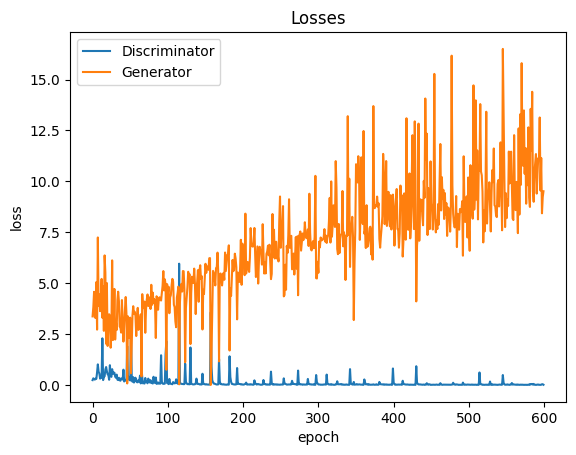

In [ ]:
# Plot losses and scores
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

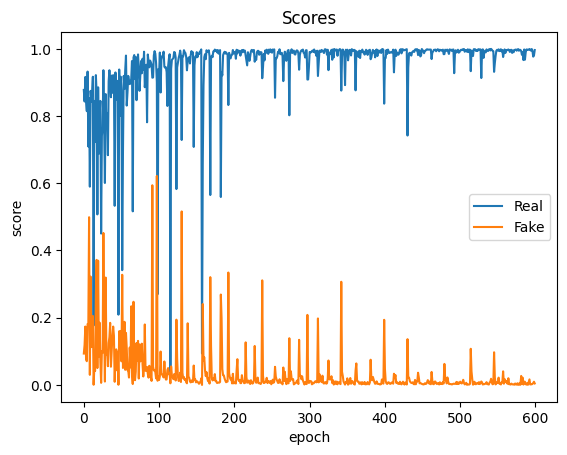

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

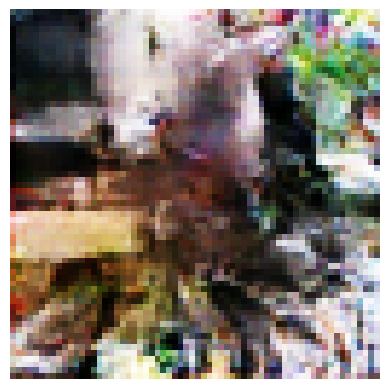

In [ ]:
def generate_single_image(latent_vector=None):
    if latent_vector is None:
        latent_vector = torch.randn(1, latent_size, 1, 1, device=device)
    with torch.no_grad():
        generated_image = generator(latent_vector).cpu().detach()
    plt.imshow(denorm(generated_image).permute(0, 2, 3, 1).squeeze(0))
    plt.axis('off')
    plt.show()

# Generate a single image
generate_single_image()

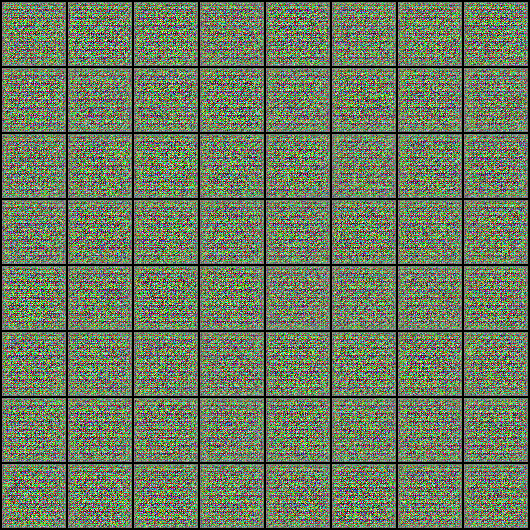

In [ ]:
from IPython.display import Image
Image('./generated/generated-images-0000.png')

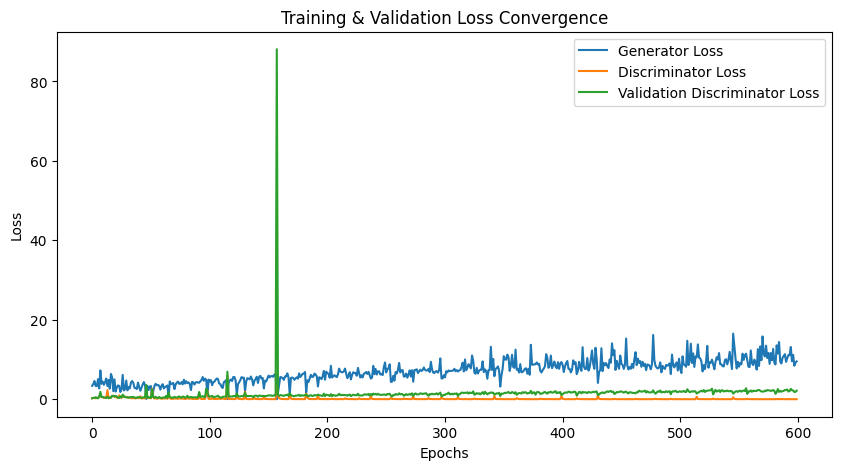

In [ ]:
def plot_loss_convergence(history):
    losses_g, losses_d, val_losses_d, _, _ = history
    plt.figure(figsize=(10, 5))
    plt.plot(losses_g, label='Generator Loss')
    plt.plot(losses_d, label='Discriminator Loss')
    plt.plot(val_losses_d, label='Validation Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss Convergence')
    plt.show()

plot_loss_convergence(history)

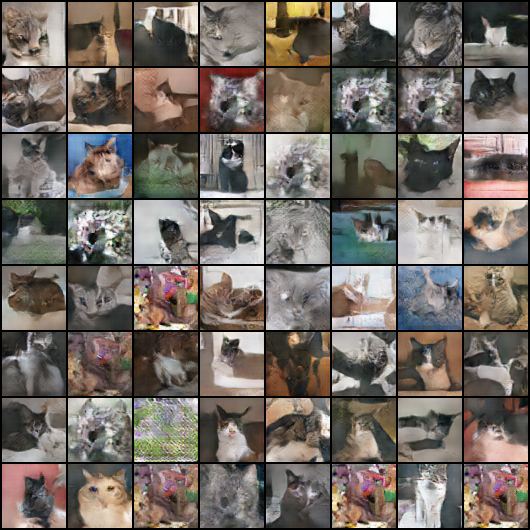

In [2]:
from IPython.display import Image
Image('./generated-images-0600.png')